# Tree partitioning

 In this section we discuss partitioning strategies for our computational domain that let us sort our sources and targets into admissible and non-admissible pairs.

Historically, Hierarchical Matrix methods use binary cluster trees to partition the computational domain, and Fast Multipole Methods use partitioning based on Octrees. In the following we will discuss both types of trees.

Before we talk about these two types of trees let us remind of the mathematical definition of a tree. We denote a graph as a tuple $G = (V, E)$, where $V$ is a set of vertices, and $E$ is a set of edges, connecting two vertices. We call a graph undirected if the edges have no orientation.

In this section we deal with a special type of undirected graph, namely a tree.

**Definition** A tree is an undirected graph $(G, E)$ in which any two vertices are connected by a unique simple path (in a simple path all vertices are distinct).

We designate one vertex in the tree as root. The parent of a vertex $v$ is the vertex directly connected to the root on the unique path to the root. The children of a verte $v$ are those vertices for which $v$ is a parent. We denote the set of children of $v$ by $\mathcal{C}(v)$.

We say that a vertex is a leaf if it has no children. We denote the set of leafs as $\mathcal{L}$.


The level $\ell(v)$ of a vertex $v$ is the number of edges on the direct path from $v$ to the root $r$. The root itself has level $0$, its children have level $1$. The depth of a tree is the maximum over all levels in the tree, that is $\text{depth} := \max_{v\in V}\ell(v)$.

For simplicity in this section we assume that we have $N$ points $x_i\in [0, 1]^d$, $i=1,\dots, N$, $d=2, 3$. By $J:=\{1, \dots, N\}$ we denote the corresponding index set.



## Cluster Trees



A cluster tree is a tree over the index set $J$ in which each vertex $v$ is associated with an index set $J_v\subset $J$ satisfying the following conditions.


- The index set of the root $r$ of the tree is $J$.
- For each vertex $v$ that is not a leaf the following two conditions hold
    - The index sets of the children of $v$ are disjoint, that is for $c, c'\in \mathcal{C}(v)$ and $c\neq c'$ we have that $J_c\cap J_{c'} = \emptyset$.
    - The union of the index sets of the children are identical to the index set of the parent, that is $J_v = \bigcup_{c\in\mathcal{C}(v)} J_c$.
- For each vertex $v$ that is not a leaf the number of children is larger than one, that is $|\mathcal{C}(v)| > 1$.
- No vertex is associated with the empty set, that is $|J_v| > 0$ for all $v\in V$.

In the following we implement simple data structures to construct a cluster tree. We have two classes, a bounding box class that stores geometric bounding boxes, and a Node class that stores an index set, allows subdivision and returns depth and leaf information.

The most important part is the subdivision. For subdivision we choose the dimension along which the bounding box is longest. We then compute the mean of the points in the index set along this dimension and separate the points by those who are smaller than the mean and those which are larger. From these we construct two new nodes.

There can be the pathological case that all points are aligned along aline. Then this strategy would leave one of the two new index sets empty. In that case we try to subdivide across the other dimension. If that fails as well we raise an exception since in that case all points in the index set are identical.

The recursive partitioning proceeds until the children have fewer than a given parameter ``nmin`` indices. This is chosen by the user and determines the depth of the tree.

In [1]:
import numpy as np

In [2]:
class BoundingBox:
    """Store a bounding box for a two dimensionsal region."""

    def __init__(self, lower_left, upper_right):
        """Define a bounding box.
        
            lower_left and upper_right are tuples of floats that
            determine the lower left and upper right corner of the
            bounding box.       
        """

        self.lower_left = lower_left
        self.upper_right = upper_right

    def longest_dimension(self):
        """Return the longest dimension."""

        xlen = self.upper_right[0] - self.lower_left[0]
        ylen = self.upper_right[1] - self.lower_left[1]

        return 0 if xlen >= ylen else 1

    def diameter(self):
        """Diameter of the bounding box."""

        return max(self.upper_right[1] - self.lower_left[1],
                   self.upper_right[0] - self.lower_left[0])

    def distance(self, other):
        """Compute distance to other bounding box."""

        def interval_distance(a0, a1, b0, b1):
            """Compute the distance between two intervals (a0, a1), (b0, b1)."""

            if a0 > b1:
                return a0 - b1
            elif b0 > a1:
                return b0 - a1
            else:
                return 0 

            # We compute the distance along each dimension

        xmin = self.lower_left[0]
        xmax = self.upper_right[0]
        ymin = self.lower_left[1]
        ymax = self.upper_right[1]

        xmin_other = other.lower_left[0]
        xmax_other = other.upper_right[0]
        ymin_other = other.lower_left[1]
        ymax_other = other.upper_right[1]

        dist1 = interval_distance(xmin, xmax, xmin_other, xmax_other)
        dist2 = interval_distance(ymin, ymax, ymin_other, ymax_other)

        return np.sqrt(dist1 * dist1 + dist2 * dist2)
        
    def subdivide(self, dim, separator):
        """Subdivide a bounding box along the given dimension.
        
            The parameter dim is either 0 (x-axis) or 1 (y-axis). The
            subdivision proceeds along this axis.

            The value separator specifies the point at which to divide up
            the bounding box.

        """

        if dim == 0:

            lower_left1 = self.lower_left
            upper_right1 = (separator, self.upper_right[1])

            lower_left2 = (separator, self.lower_left[1])
            upper_right2 = self.upper_right

        elif dim == 1:

            lower_left1 = self.lower_left
            upper_right1 = (self.upper_right[0], separator)

            lower_left2 = (self.lower_left[0], separator)
            upper_right2 = self.upper_right
        else:
            raise NotImplementedError

        return (BoundingBox(lower_left1, upper_right1), 
                BoundingBox(lower_left2, upper_right2))
            

In [3]:
class Node:
    """
    Stores information about nodes of a cluster tree and allows
    subdivision of a node.
    """

    def __init__(self, parent, indices, bounding_box, points):
        """
        Create a new node with given parent and indices.
        
        The bounding box has the form [(x_1, y_1), (x_2, y_2)]
        denoting the lower left and upper right point defining the
        bounding box for the index set.

        The variable points stores the original point set as Numpy
        array of shape (2, N).
        
        """

        self.parent = parent
        self.indices = indices
        self.children = None
        self.bounding_box = bounding_box
        self.points = points

    def subdivide(self):
        """Subdivide node along longest dimension."""

        dim = self.bounding_box.longest_dimension()

        first_set, second_set, separator = self.subdivide_impl(dim)

        if len(first_set) == 0 or len(second_set) == 0:
            # Subdivision along this axis did not work
            # Subdivide along the other axis

            dim = 1 - dim # Works since dim is either 0 or 1

            first_set, second_set, separator = self.subdivide_impl(dim)

            if len(first_set) == 0 or len(second_set) == 0:
                print(first_set)
                print(second_set)
                raise Exception("Subdivision not possible")

    
        bounding_box1, bounding_box2 = self.bounding_box.subdivide(dim, separator)

        node1 = Node(self, first_set, bounding_box1, points)
        node2 = Node(self, second_set, bounding_box2, points)

        return [node1, node2]

    def expand_to_tree(self, nmin):
        """Recursively subdivide until each index set of the descendents is smaller than nmin."""

        if len(self.indices) < nmin:
            return

        self.children = self.subdivide()
        self.children[0].expand_to_tree(nmin)
        self.children[1].expand_to_tree(nmin)

    def subdivide_impl(self, dim):
        """Implement the subdividison."""

        if len(self.indices) < 2:
            raise ValueError("No further subdivision possible.")

        median = np.median(self.points[dim, self.indices])

        first_set = self.indices[self.points[dim, self.indices] < median]
        second_set = self.indices[self.points[dim, self.indices] >= median]

        return (first_set, second_set, median)

    def leafs(self):
        """Return the leaf descendents of the node."""

        if self.children is None:
            return [self]
        else:
            return self.children[0].leafs() + self.children[1].leafs()

    def depth(self):
        """Return the depth of the tree from the current node."""

        if self.children is None:
            return 0
        else:
            return 1 + max(self.children[0].depth(), self.children[1].depth())
            
    

In the following we discretise the unit circle, generate the corresponding cluster tree and draw the associated leaf boxes.

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

def sphere_points(N):
    """Create a sphere from N points."""
    z = np.exp(1j * 2 * np.pi / N * np.arange(N))
    points = np.array([np.real(z), np.imag(z)])
    return points

def draw_patch(lower_left, upper_right, ax):
    """Helper function to draw a rectangular patch."""
    from matplotlib.patches import Rectangle

    origin = lower_left
    width = upper_right[0] - lower_left[0]
    height = upper_right[1] - lower_left[1]

    ax.add_patch(Rectangle(origin, width, height, linewidth=1, edgecolor='k', fill=False))



In [5]:
N = 1001
nmin = 20

lower_left = (-1.1, -1.1)
upper_right = (1.1, 1.1)
points = sphere_points(N)

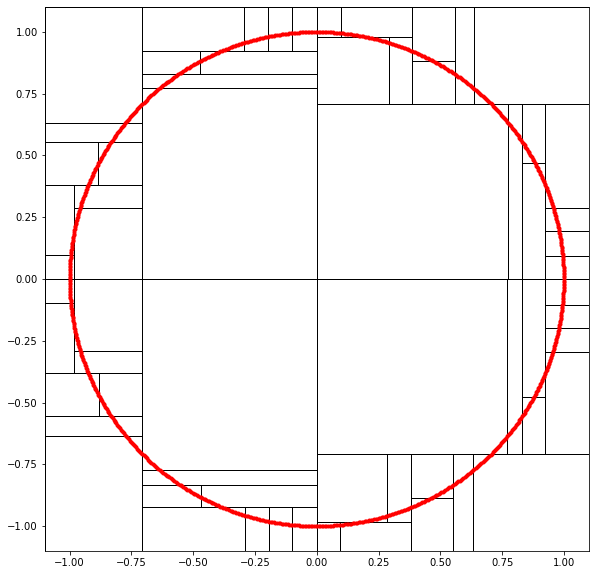

In [6]:
import numpy as np

bounding_box = BoundingBox(lower_left, upper_right)
root = Node([], np.arange(N), bounding_box, points)
root.expand_to_tree(nmin)

leafs = root.leafs()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, aspect='equal')
ax.set_xlim(lower_left[0], upper_right[0])
ax.set_ylim(lower_left[1], upper_right[1])

for leaf in leafs:

    lower_left, upper_right = leaf.bounding_box.lower_left, leaf.bounding_box.upper_right
    draw_patch(lower_left, upper_right, ax)

ax.plot(points[0, :], points[1, :], 'r.')





The figure demonstrates how the partitioning refines around the circle, attempting to keep similar numbers of points per box. Cluster trees are simple and as shown above, easy to implement. However, their non-uniform structure is not suitable for all types of applications. This is addressed by Octrees.

## Octrees

An octree (or quadtree in two dimensions) is a regular geometric partitioning. Instead of balancing the number of points per box an Octree/Quadtree subdivides a cube/square into 8/4 identically sized child cube/squares. The advantage is a uniform data structure. The boxes on a given level are all identical, making this structure ideal for methods that rely on this uniformity on each level.

We will not go into implementational details here. Even though Octrees/Quadtrees are simple in principle efficient indexing of them is an interesting problem that is solved by Morton encoding, which is based on Z-curve traversals of the tree. This topic leads very much into the realm of computer graphics and associated topics.

Below is a simple quadtree implementationt together with the corresponding plot of an adaptive quadtree for the unit circle. More efficient implementations would use the above mentioned techniques based on Morton encoding of boxes.



In [7]:
class QuadTreeNode:
    """Store a node of a quadtree."""

    def __init__(self, parent, indices, lower_left, upper_right, points):
        """
        Initialize a quadtree node with parent and lower left
        and upper right corner of associated geometric bounding box.    
        """

        self.lower_left = lower_left
        self.upper_right = upper_right
        self.parent = parent
        self.children = None
        self.indices = indices
        self.points = points

    def expand_to_tree(self, nmin):
        """Subdivide a node recursively until each box has fewer than nmin indices."""

        if len(self.indices) < nmin:
            return

        # Now truly subdivide

        xmid = (self.lower_left[0] + self.upper_right[0]) / 2
        ymid = (self.lower_left[1] + self.upper_right[1]) / 2

        boxes = 4 * [None]

        boxes[0] = (self.lower_left, (xmid, ymid))
        boxes[1] = ((xmid, self.lower_left[1]), (self.upper_right[0], ymid))
        boxes[2] = ((self.lower_left[0], ymid), (xmid, self.upper_right[1]))
        boxes[3] = ((xmid, ymid), self.upper_right)

        # For each box we need to take the containing points and create the
        # corresponding node.

        self.children = 4 * [None]

        for index, box in enumerate(boxes):

            contained = np.ones(len(self.indices), dtype=bool)

            contained = contained & (box[0][0] <= self.points[0, self.indices])
            contained = contained & (box[0][1] <= self.points[1, self.indices])
            contained = contained & (self.points[0, self.indices] < box[1][0])
            contained = contained & (self.points[1, self.indices] < box[1][1])

            my_indices = self.indices[contained]

            self.children[index] = QuadTreeNode(self, my_indices, box[0], box[1], self.points)
            self.children[index].expand_to_tree(nmin)

        
    def leafs(self):
        """Return the leaf descendents of the node."""

        if self.children is None:
            return [self]
        else:
            result = []

            for index in range(4):
                result += self.children[index].leafs()

            return result

    def depth(self):
        """Return the depth of the tree from the current node."""

        if self.children is None:
            return 0
        else:
            return 1 + max([self.children[index].depth() for index in range(4)])










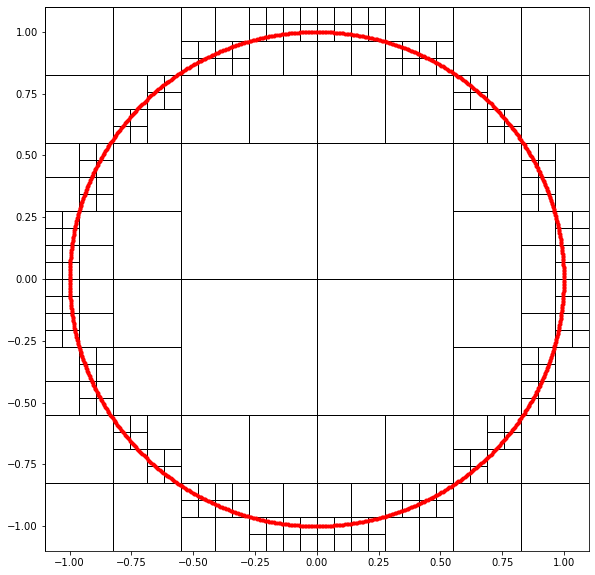

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline

N = 1001
nmin = 20

lower_left = (-1.1, -1.1)
upper_right = (1.1, 1.1)
points = sphere_points(N)

root = QuadTreeNode([], np.arange(N), lower_left, upper_right, points)
root.expand_to_tree(nmin)

def node_to_patch(node):
    """Helper function that turns a node into a matplotlib rectangle patch."""
    from matplotlib.patches import Rectangle

    lower_left, upper_right = (node.lower_left, node.upper_right)

    origin = lower_left
    width = upper_right[0] - lower_left[0]
    height = upper_right[1] - lower_left[1]

    return Rectangle(origin, width, height, linewidth=1, edgecolor='k', fill=False)

leafs = root.leafs()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, aspect='equal')
ax.set_xlim(lower_left[0], upper_right[0])
ax.set_ylim(lower_left[1], upper_right[1])

for leaf in leafs:
    ax.add_patch(
        node_to_patch(leaf)
    )

ax.plot(points[0, :], points[1, :], 'r.')



In [9]:
len(root.leafs())

64

The advantage of octrees/quadtrees is visible. The data structure is uniform. However, we create more children than in a simple binary cluster tree. Traditionally octrees/quadtrees are used for Fast Multipole type methods and binary cluster trees are used for Hierarchical Matrices.

## Block-Cluster Trees

Recall the Green's function interaction matrix $G$ defined by $G[i, j] = g(x_i, y_j)$, where the $x_i$ are targets and the $y_j$ are sources. A cluster tree or octree/quadtree gives us a recursive partitioning of the sources and targets. But it does not yet give us information about which interactions between sources and targets satisfy an admissibility condition. This is solved by Block-Cluster Trees.

Let $I$ and $J$ by index sets with corresponding cluster trees $T_I$ and $T_J$. Each node $v$ of the block-cluster tree is identified with the direct product $\tau\times\nu$ of nodes $\tau$ of $T_I$ and $\nu$ of $T_J$. The corresponding index set is the cross-product $I_\tau\times J_\nu$.


We create a block-cluster tree $T_{I\times J}$ as follows.

- The root of the tree is the cross product of the roots of $T_I$ and $T_J$.
- Let $v$ be a node of $T_{I\times J}$ identified with the cross-product $\tau\times\nu$ of nodes $\tau$ of $T_I$ and $\nu$ of $T_J$, and index set $I_\tau\times J_\nu$.
  - It is a leaf if $I_\tau\times J_\nu$ satisfies an admissibility condition or if one of the sets of children $\mathcal{C}(\tau)$ or $\mathcal{C}(\nu)$ is empty.
  - If $v$ is not a leaf then its children are defined through $\mathcal{C}(v) := \{\tau'\times \nu': \tau'\in\mathcal{C}(\tau), \nu'\in\mathcal{C}(\nu)\}$, that is the children of $v$ are defined as the cross-products of the children of $\tau$ and $\nu$.


How do we check if an index set $\I_\tau\times $J_\nu$ satisfies an admissibility condition?

For a source set $Y$ and a target set $X$ we defined earlier the admissibility condition

$$
\min \{\text{diam}(X), \text{diam}(Y)\} \leq \eta\, \text{dist}(X, Y).
$$

In our tree algorithms we use bounding boxes associated with points contained in them. Hence, instead of checking the admissibility condition pointwise, we simply evaluate the diameter and distance of the associated bounding boxes.

In the following we want to implement a simple block-clustering algorithm. Each node of the block-cluster tree will store the tuple of the corresponding nodes of the source and target tree.

In [34]:
class BlockClusterNode:
    """Node of a block cluster tree."""

    def __init__(self, source_node, target_node, eta):
        """
        Define the node of a block-cluster tree.

        source_node and target_node are nodes from the source and
        target tree. 

        The parameter eta is the tolerance in the admissibility condition.

        """

        self.source_node = source_node
        self.target_node = target_node
        self.eta = eta
        self.children = None

        source_diam = source_node.bounding_box.diameter()
        target_diam = target_node.bounding_box.diameter()

        dist = source_node.bounding_box.distance(target_node.bounding_box)
        self.is_admissible = min(source_diam, target_diam) <= eta * dist

    def expand_to_tree(self):
        """Expand node to a tree."""

        if self.is_admissible:
            return

        if self.source_node.children is None:
            return

        if self.target_node.children is None:
            return

        self.children = []

        for source_child in self.source_node.children:
            for target_child in self.target_node.children:
                new_child = BlockClusterNode(source_child, target_child, self.eta)
                self.children.append(
                    new_child
                )
                new_child.expand_to_tree()


    def leafs(self):
        """Return the leaf descendents of the node."""

        if self.children is None:
            return [self]
        else:
            result = []

            for index in range(4):
                result += self.children[index].leafs()

            return result

    def depth(self):
        """Return the depth of the tree from the current node."""

        if self.children is None:
            return 0
        else:
            return 1 + max([self.children[index].depth() for index in range(4)])

        




In [44]:
N = 100
nmin = 10

lower_left = (-1.1, -1.1)
upper_right = (1.1, 1.1)
points = sphere_points(N)

N = points.shape[1]
eta = 1.2

bounding_box = BoundingBox(lower_left, upper_right)
root = Node([], np.arange(N), bounding_box, points)
root.expand_to_tree(nmin)

leafs = root.leafs()

permutation = np.zeros(N, dtype=np.int64)
count = 0
for leaf in leafs:
    for i, value in enumerate(leaf.indices):
        permutation[value] = count
        count += 1

def permute_indices(node, permutation):

    for i, value in enumerate(node.indices):
        node.indices[i] = permutation[value]

    if node.children is not None:
        for child in node.children:
            permute_indices(child, permutation)

permute_indices(root, permutation)

block_cluster_root = BlockClusterNode(root, root, 1.2)
block_cluster_root.expand_to_tree()

block_cluster_leafs = block_cluster_root.leafs()

def draw_block_cluster_patch(node, ax):
    """Helper function to draw a rectangular patch."""
    from matplotlib.patches import Rectangle

    source_indices = node.source_node.indices
    target_indices = node.target_node.indices

    width = source_indices[-1] - source_indices[0]
    height = target_indices[-1] - target_indices[0]

    if width > 8 and height > 8:
        print(source_indices)

    origin = (source_indices[0], target_indices[0])

    if node.is_admissible:
        fc = 'g'
    else:
        fc = 'r'


    ax.add_patch(Rectangle(origin, width, height, linewidth=1, edgecolor='k', fc=fc, fill=True))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, aspect='equal')
ax.set_xlim(0, N - 1)
ax.set_ylim(0, N - 1)

for index, leaf in enumerate(block_cluster_leafs):
    draw_block_cluster_patch(leaf, ax)



KeyboardInterrupt: 

In [36]:
for leaf in block_cluster_leafs:
    if leaf.source_node.indices[0] == 0 and leaf.target_node.indices[-1] == 1000:
        print("Here")

In [155]:
leaf.source_node.indices

array([351, 352, 353, 354, 355, 356, 357, 358])

In [156]:
leaf.target_node.indices

array([335, 336, 337, 338, 339, 340, 341, 342])

In [43]:
root.indices[0]

0